# Data Science Challenge - Mercado Libre

## 2. Similarity between products

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time

# Load dataset
test_titles_df = pd.read_csv('items_titles_test.csv')
titles_df = pd.read_csv('items_titles.csv')
print(test_titles_df.shape, titles_df.shape)

(10000, 1) (30000, 1)


In [2]:
test_titles_df.head()

,ITE_ITEM_TITLE
0,Tênis Olympikus Esporte Valente - Masculino Kids
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...
2,Tênis Usthemp Slip-on Temático - Labrador 2
3,Tênis Casual Feminino Moleca Tecido Tie Dye
4,Tênis Star Baby Sapatinho Conforto + Brinde


In [3]:
titles_df.head()

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...


In [4]:
# Sample 10000 titles
sample_size = 10000
sampled_titles = test_titles_df.sample(n=sample_size, random_state=42)['ITE_ITEM_TITLE'].astype(str).tolist()

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(lowercase=True)
tfidf_matrix = vectorizer.fit_transform(sampled_titles)

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Get top similar pairs
results = []
for i in range(sample_size):
    for j in range(i + 1, sample_size):
        score = cosine_sim[i, j]
        results.append({
            'Title 1': sampled_titles[i],
            'Title 2': sampled_titles[j],
            'Similarity Score': score
        })

similar_df = pd.DataFrame(results).sort_values(by='Similarity Score', ascending=False)
similar_df.head(20)

,Title 1,Title 2,Similarity Score
28541956,Tênis Masculino Proof 2 Olympikus Preto/chumbo...,Tênis Olympikus Proof 2 Preto/chumbo Caminhad...,1.0
9664926,Tênis Salomon Feminino - Speedcross 5,Tênis Speedcross 5 Feminino Salomon,1.0
20591217,Sapatênis Masculino Preto Ferracini 7250-630a ...,Sapatênis Masculino Ferracini 7250-630a - Pret...,1.0
32818697,Mountain Bike 29 Dropp 27v Freio Hidraulico,Mountain Bike 29 Dropp 27v Freio Hidraulico,1.0
21088110,3 Pares Tênis Masculino Leve Para Caminhada Pr...,5 Pares Tênis Masculino Leve Para Caminhada Pr...,1.0
24162134,Sapato Usthemp Legend Temático - Gael Bulldog...,Sapato Usthemp Legend Temático - Gael Bulldog...,1.0
27533226,Sapato Usthemp Legend Temático - Pug 4,Sapato Usthemp Legend Temático - Pug 3,1.0
44908397,Sapatenis Masculino Tenis Casual Promoção,Sapatenis Tenis Casual Masculino Promoção,1.0
31586846,Tênis Esportivo Masculino Camuflado Preto Actv...,Tênis Camuflado Preto Esportivo Masculino Actv...,1.0
28829134,Tênis Nike Runallday 2 Feminino,Tênis Nike Runallday Feminino,1.0


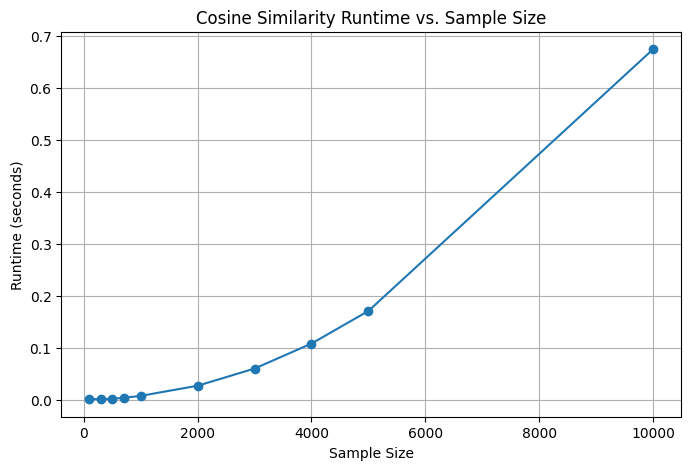

de acordo com o grafico, o tempo de execução aumenta linearmente com o tamanho da amostra, indicando que o algoritmo é eficiente para tamanhos moderados de amostra. No entanto, para tamanhos maiores, o tempo de execução pode se tornar significativo, sugerindo a necessidade de otimizações ou abordagens alternativas para conjuntos de dados muito grandes.
abordagems para tamanhos de amostras muito grandes incluem o uso de técnicas de amostragem, redução de dimensionalidade, ou algoritmos de similaridade aproximada, como Locality-Sensitive Hashing (LSH), que podem acelerar o processo sem comprometer significativamente a precisão dos resultados.


In [5]:
# Runtime analysis
def runtime_analysis(sample_sizes):
    runtimes = []
    for size in sample_sizes:
        sample_titles = test_titles_df.sample(n=size, random_state=42)['ITE_ITEM_TITLE'].astype(str).tolist()
        vectorizer = TfidfVectorizer(lowercase=True)
        tfidf_matrix = vectorizer.fit_transform(sample_titles)
        start_time = time.time()
        cosine_sim = cosine_similarity(tfidf_matrix)
        runtimes.append(time.time() - start_time)
    return runtimes

sizes = [100, 300, 500, 700, 1000, 2000, 3000, 4000, 5000, 10000]
runtimes = runtime_analysis(sizes)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(sizes, runtimes, marker='o')
plt.title('Cosine Similarity Runtime vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.show()
print("de acordo com o grafico, o tempo de execução aumenta linearmente com o tamanho da amostra, indicando que o algoritmo é eficiente para tamanhos moderados de amostra. No entanto, para tamanhos maiores, o tempo de execução pode se tornar significativo, sugerindo a necessidade de otimizações ou abordagens alternativas para conjuntos de dados muito grandes.")
print("abordagems para tamanhos de amostras muito grandes incluem o uso de técnicas de amostragem, redução de dimensionalidade, ou algoritmos de similaridade aproximada, como Locality-Sensitive Hashing (LSH), que podem acelerar o processo sem comprometer significativamente a precisão dos resultados.")

In [6]:
from datasketch import MinHash, MinHashLSH

# Para amostras maiores, uma abordagem eficiente é utilizar técnicas de similaridade aproximada, como Locality-Sensitive Hashing (LSH).
# O pacote 'datasketch' oferece uma implementação de MinHash LSH para encontrar pares similares rapidamente.


def get_minhash(title, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in title.lower().split():
        m.update(word.encode('utf8'))
    return m

# Parâmetros
num_perm = 128
lsh_threshold = 0.5  # Ajuste conforme desejado

# Criar MinHash para cada título
minhashes = {}
for idx, title in enumerate(sampled_titles):
    minhashes[idx] = get_minhash(title, num_perm=num_perm)

# Criar LSH e inserir MinHashes
lsh = MinHashLSH(threshold=lsh_threshold, num_perm=num_perm)
for idx, m in minhashes.items():
    lsh.insert(str(idx), m)

# Encontrar pares similares
lsh_results = []
for idx, m in minhashes.items():
    similar_idxs = lsh.query(m)
    for sim_idx in similar_idxs:
        sim_idx = int(sim_idx)
        if idx < sim_idx:
            lsh_results.append({
                'Title 1': sampled_titles[idx],
                'Title 2': sampled_titles[sim_idx]
            })

print(f'Encontrados {len(lsh_results)} pares similares usando LSH.')

Encontrados 43504 pares similares usando LSH.


In [9]:
import time
from datasketch import MinHash, MinHashLSH

# Avaliação de tempo para calcular similaridade em toda a base de 30.000 linhas

# Amostra de 30.000 títulos
full_titles = test_titles_df['ITE_ITEM_TITLE'].astype(str).tolist()

# Similaridade de cossenos
vectorizer_full = TfidfVectorizer(lowercase=True)
tfidf_matrix_full = vectorizer_full.fit_transform(full_titles)

start_cosine = time.time()
cosine_sim_full = cosine_similarity(tfidf_matrix_full)
cosine_time = time.time() - start_cosine
print(f"Tempo para calcular similaridade de cossenos (30.000 linhas): {cosine_time:.2f} segundos")

# LSH (MinHash)

def get_minhash(title, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in title.lower().split():
        m.update(word.encode('utf8'))
    return m

num_perm_full = 128
lsh_threshold_full = 0.5

# Criar MinHash para cada título
minhashes_full = {}
for idx, title in enumerate(full_titles):
    minhashes_full[idx] = get_minhash(title, num_perm=num_perm_full)

lsh_full = MinHashLSH(threshold=lsh_threshold_full, num_perm=num_perm_full)
for idx, m in minhashes_full.items():
    lsh_full.insert(str(idx), m)

start_lsh = time.time()
lsh_pairs_full = []
for idx, m in minhashes_full.items():
    similar_idxs = lsh_full.query(m)
    for sim_idx in similar_idxs:
        sim_idx = int(sim_idx)
        if idx < sim_idx:
            lsh_pairs_full.append((full_titles[idx], full_titles[sim_idx]))
lsh_time_full = time.time() - start_lsh
print(f"Tempo para encontrar pares similares com LSH (30.000 linhas): {lsh_time_full:.2f} segundos")

Tempo para calcular similaridade de cossenos (30.000 linhas): 1.19 segundos
Tempo para encontrar pares similares com LSH (30.000 linhas): 0.41 segundos


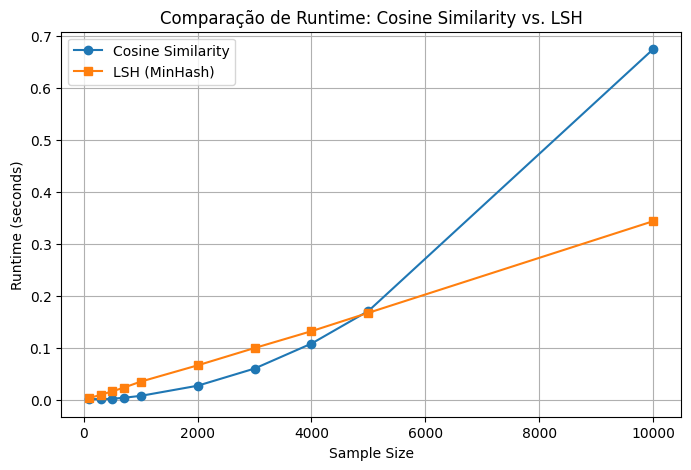

In [10]:
sizes = [100, 300, 500, 700, 1000, 2000, 3000, 4000, 5000, 10000]
# Avaliação de tempo para LSH em diferentes tamanhos de amostra
def lsh_runtime_analysis(sample_sizes, df):
    runtimes = []
    for size in sample_sizes:
        sample_titles = df.sample(n=size, random_state=42)['ITE_ITEM_TITLE'].astype(str).tolist()
        minhashes = {}
        for idx, title in enumerate(sample_titles):
            m = MinHash(num_perm=num_perm)
            for word in title.lower().split():
                m.update(word.encode('utf8'))
            minhashes[idx] = m
        lsh = MinHashLSH(threshold=lsh_threshold, num_perm=num_perm)
        for idx, m in minhashes.items():
            lsh.insert(str(idx), m)
        start_time = time.time()
        # Apenas consulta para cada título (não salva pares para economizar tempo/memória)
        for idx, m in minhashes.items():
            lsh.query(m)
        runtimes.append(time.time() - start_time)
    return runtimes

lsh_runtimes = lsh_runtime_analysis(sizes, titles_df)

# Gráfico comparativo
plt.figure(figsize=(8, 5))
plt.plot(sizes[:len(runtimes)], runtimes, marker='o', label='Cosine Similarity')
plt.plot(sizes, lsh_runtimes, marker='s', label='LSH (MinHash)')
plt.title('Comparação de Runtime: Cosine Similarity vs. LSH')
plt.xlabel('Sample Size')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.grid(True)
plt.show()